# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
import closs
import ccall

from simplegen import SIMPLESequence
from lastengen import LASTENSequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 7.1) Supervised Euclidean for LASTEN with fixed image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/7_1_euclidean'

path_fixed = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/fix'
path_train = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/train'
path_validation = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/validation'
path_test = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN/test'

#path_fixed = r'D:\Julian\data\SIMPLED\train\0'
#path_train = r'D:\Julian\data\SIMPLED\train'
#path_validation = r'D:\Julian\data\SIMPLED\validation'
#path_test = r'D:\Julian\data\SIMPLED\test'

width = 384
height = 384

grid_width = 18
grid_height = 18

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(width, height, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
batch_size=2

train_gen = LASTENSequence(path_train,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=True,
                           label="keypoints",
                           channel="moving+fixed")

val_gen = LASTENSequence(path_validation,
                           path_fixed,
                           batch_size=batch_size,
                           width=width,
                           height=height,
                           grid_width=grid_width, 
                           grid_height=grid_height,
                           preprocess_input=pre_une,
                           shuffle=False,
                           label="keypoints",
                           channel="moving+fixed")

logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
timelogger = ccall.TimeHistory(store_path)
#vallogger = ccall.ValidationHistory(store_path, val_gen)
callbacks = [logger, checker, timelogger]#, vallogger]

eu_loss = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='msed')
eu_metric = closs.EuclideanLoss(batch_size=batch_size, grid_width=grid_width, grid_height=grid_height, loss_type='maed')

model.compile(optimizer='adam', loss=eu_loss, metrics=[eu_metric])

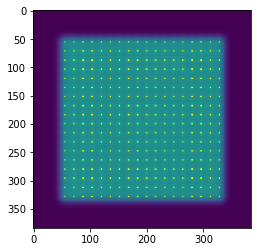

In [8]:
X, y = train_gen[0]

plt.imshow(X[0,:,:,1])

# Training
Run the training.

In [9]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=val_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Epoch 1/100


/home/julian/anaconda3/envs/endolas/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


84/84 [==============================] - 50s 593ms/step - loss: 1049.9202 - maed: 27.3108 - val_loss: 37470.6211 - val_maed: 168.3500
Epoch 2/100
84/84 [==============================] - 48s 569ms/step - loss: 448.5847 - maed: 17.1527 - val_loss: 1187.1749 - val_maed: 30.1902
Epoch 3/100
84/84 [==============================] - 49s 578ms/step - loss: 207.2561 - maed: 11.8565 - val_loss: 492.5006 - val_maed: 19.2281
Epoch 4/100
84/84 [==============================] - 50s 590ms/step - loss: 159.9155 - maed: 10.3698 - val_loss: 415.9632 - val_maed: 17.4216
Epoch 5/100
84/84 [==============================] - 50s 590ms/step - loss: 108.6820 - maed: 8.6847 - val_loss: 222.7081 - val_maed: 12.9591
Epoch 6/100
84/84 [==============================] - 49s 589ms/step - loss: 74.1626 - maed: 7.1933 - val_loss: 139.7072 - val_maed: 9.6340
Epoch 7/100
84/84 [==============================] - 49s 587ms/step - loss: 67.6786 - maed: 6.8350 - val_loss: 171.4549 - val_maed: 11.0306
Epoch 8/100
84/84 [

84/84 [==============================] - 50s 589ms/step - loss: 39.9984 - maed: 5.2423 - val_loss: 572.9471 - val_maed: 21.0105
Epoch 10/100
84/84 [==============================] - 48s 568ms/step - loss: 41.2864 - maed: 5.2879 - val_loss: 75.9504 - val_maed: 7.6376
Epoch 11/100
84/84 [==============================] - 48s 577ms/step - loss: 24.7521 - maed: 4.2134 - val_loss: 54.8627 - val_maed: 6.1082
Epoch 12/100
84/84 [==============================] - 48s 577ms/step - loss: 19.6164 - maed: 3.7265 - val_loss: 60.0362 - val_maed: 6.6298
Epoch 13/100
84/84 [==============================] - 49s 583ms/step - loss: 28.3743 - maed: 4.4872 - val_loss: 45.4813 - val_maed: 5.7824
Epoch 14/100
84/84 [==============================] - 49s 588ms/step - loss: 29.5182 - maed: 4.5597 - val_loss: 58.6732 - val_maed: 6.7425
Epoch 15/100
84/84 [==============================] - 50s 592ms/step - loss: 21.7433 - maed: 3.8989 - val_loss: 25.3808 - val_maed: 4.2826
Epoch 16/100
84/84 [==================

Epoch 18/100
84/84 [==============================] - 47s 559ms/step - loss: 15.2783 - maed: 3.2723 - val_loss: 24.4182 - val_maed: 4.2893
Epoch 19/100
84/84 [==============================] - 47s 559ms/step - loss: 18.6029 - maed: 3.5630 - val_loss: 59.6809 - val_maed: 6.6930
Epoch 20/100
84/84 [==============================] - 49s 582ms/step - loss: 13.9525 - maed: 3.1145 - val_loss: 32.5382 - val_maed: 4.8456
Epoch 21/100
84/84 [==============================] - 50s 591ms/step - loss: 14.7824 - maed: 3.1831 - val_loss: 40.4871 - val_maed: 5.6578
Epoch 22/100
84/84 [==============================] - 49s 589ms/step - loss: 15.2148 - maed: 3.2339 - val_loss: 33.8846 - val_maed: 4.9548
Epoch 23/100
84/84 [==============================] - 50s 590ms/step - loss: 10.0026 - maed: 2.6497 - val_loss: 39.9425 - val_maed: 5.5588
Epoch 24/100
84/84 [==============================] - 50s 590ms/step - loss: 8.4490 - maed: 2.4167 - val_loss: 26.0270 - val_maed: 4.3334
Epoch 25/100
84/84 [========

84/84 [==============================] - 50s 592ms/step - loss: 18.4567 - maed: 3.5559 - val_loss: 70.7192 - val_maed: 6.5348
Epoch 27/100
84/84 [==============================] - 49s 584ms/step - loss: 18.5536 - maed: 3.5590 - val_loss: 32.1062 - val_maed: 4.6568
Epoch 28/100
84/84 [==============================] - 49s 579ms/step - loss: 14.4343 - maed: 3.1810 - val_loss: 14.1944 - val_maed: 3.0920
Epoch 29/100
84/84 [==============================] - 48s 576ms/step - loss: 7.6303 - maed: 2.3195 - val_loss: 52.1078 - val_maed: 6.0389
Epoch 30/100
84/84 [==============================] - 49s 580ms/step - loss: 9.1876 - maed: 2.5137 - val_loss: 28.6285 - val_maed: 4.6978
Epoch 31/100
84/84 [==============================] - 48s 577ms/step - loss: 15.9650 - maed: 3.3284 - val_loss: 104.9470 - val_maed: 8.6770
Epoch 32/100
84/84 [==============================] - 48s 577ms/step - loss: 17.1812 - maed: 3.4515 - val_loss: 32.6058 - val_maed: 4.7710
Epoch 33/100
84/84 [=====================

Epoch 35/100
84/84 [==============================] - 47s 554ms/step - loss: 11.4096 - maed: 2.8059 - val_loss: 46.3971 - val_maed: 5.5047
Epoch 36/100
84/84 [==============================] - 47s 556ms/step - loss: 10.0800 - maed: 2.6181 - val_loss: 49.0923 - val_maed: 6.1851
Epoch 37/100
84/84 [==============================] - 47s 557ms/step - loss: 12.8146 - maed: 2.9616 - val_loss: 52.4480 - val_maed: 6.2121
Epoch 38/100
84/84 [==============================] - 47s 555ms/step - loss: 17.3882 - maed: 3.4687 - val_loss: 64.1152 - val_maed: 5.9789
Epoch 39/100
84/84 [==============================] - 47s 555ms/step - loss: 14.2308 - maed: 3.1474 - val_loss: 26.5119 - val_maed: 4.5847
Epoch 40/100
84/84 [==============================] - 47s 558ms/step - loss: 8.0744 - maed: 2.3874 - val_loss: 17.8649 - val_maed: 3.5044
Epoch 41/100
84/84 [==============================] - 47s 555ms/step - loss: 8.2676 - maed: 2.3957 - val_loss: 13.2628 - val_maed: 3.1165
Epoch 42/100
84/84 [=========

84/84 [==============================] - 47s 556ms/step - loss: 6.5235 - maed: 2.1162 - val_loss: 11.5193 - val_maed: 2.7726
Epoch 44/100
84/84 [==============================] - 47s 557ms/step - loss: 10.2392 - maed: 2.6221 - val_loss: 28.6087 - val_maed: 4.4914
Epoch 45/100
84/84 [==============================] - 47s 555ms/step - loss: 11.6181 - maed: 2.8078 - val_loss: 35.1301 - val_maed: 5.1897
Epoch 46/100
84/84 [==============================] - 47s 555ms/step - loss: 6.8156 - maed: 2.1892 - val_loss: 18.8971 - val_maed: 3.7987
Epoch 47/100
84/84 [==============================] - 47s 558ms/step - loss: 6.7575 - maed: 2.1486 - val_loss: 14.7798 - val_maed: 3.2406
Epoch 48/100
84/84 [==============================] - 47s 555ms/step - loss: 4.2825 - maed: 1.7370 - val_loss: 12.0689 - val_maed: 2.9240
Epoch 49/100
84/84 [==============================] - 47s 557ms/step - loss: 4.1693 - maed: 1.7135 - val_loss: 13.7590 - val_maed: 3.2082
Epoch 50/100
84/84 [=========================

Epoch 52/100
84/84 [==============================] - 47s 554ms/step - loss: 7.5878 - maed: 2.3185 - val_loss: 17.1880 - val_maed: 3.5146
Epoch 53/100
84/84 [==============================] - 47s 557ms/step - loss: 18.7738 - maed: 3.5495 - val_loss: 71.9244 - val_maed: 7.1224
Epoch 54/100
84/84 [==============================] - 47s 555ms/step - loss: 14.4655 - maed: 3.1870 - val_loss: 44.6691 - val_maed: 5.5822
Epoch 55/100
84/84 [==============================] - 47s 557ms/step - loss: 9.4007 - maed: 2.5604 - val_loss: 89.8987 - val_maed: 8.0128
Epoch 56/100
84/84 [==============================] - 47s 555ms/step - loss: 32.1476 - maed: 4.6091 - val_loss: 45.7573 - val_maed: 5.5946
Epoch 57/100
84/84 [==============================] - 47s 555ms/step - loss: 14.6626 - maed: 3.2027 - val_loss: 49.5233 - val_maed: 5.7963
Epoch 58/100
84/84 [==============================] - 47s 556ms/step - loss: 7.5334 - maed: 2.3073 - val_loss: 7.3165 - val_maed: 2.3078
Epoch 59/100
84/84 [===========

84/84 [==============================] - 47s 560ms/step - loss: 5.4532 - maed: 1.9005 - val_loss: 20.0101 - val_maed: 3.8386
Epoch 61/100
84/84 [==============================] - 47s 557ms/step - loss: 7.5440 - maed: 2.2879 - val_loss: 25.8853 - val_maed: 4.3391
Epoch 62/100
84/84 [==============================] - 47s 557ms/step - loss: 3.7749 - maed: 1.6284 - val_loss: 9.0722 - val_maed: 2.5755
Epoch 63/100
84/84 [==============================] - 47s 555ms/step - loss: 4.2486 - maed: 1.7237 - val_loss: 7.3133 - val_maed: 2.1343
Epoch 64/100
84/84 [==============================] - 47s 559ms/step - loss: 3.1841 - maed: 1.4944 - val_loss: 14.5301 - val_maed: 3.2856
Epoch 65/100
84/84 [==============================] - 47s 555ms/step - loss: 8.1395 - maed: 2.3473 - val_loss: 23.0543 - val_maed: 3.6376
Epoch 66/100
84/84 [==============================] - 47s 555ms/step - loss: 7.4214 - maed: 2.2739 - val_loss: 34.3488 - val_maed: 5.1839
Epoch 67/100
84/84 [=============================

Epoch 69/100
84/84 [==============================] - 47s 554ms/step - loss: 5.9575 - maed: 2.0380 - val_loss: 16.3162 - val_maed: 3.4383
Epoch 70/100
84/84 [==============================] - 47s 560ms/step - loss: 8.0999 - maed: 2.3695 - val_loss: 42.9190 - val_maed: 5.5199
Epoch 71/100
84/84 [==============================] - 47s 558ms/step - loss: 9.1655 - maed: 2.5503 - val_loss: 20.3939 - val_maed: 3.8369
Epoch 72/100
84/84 [==============================] - 47s 554ms/step - loss: 5.6726 - maed: 1.9912 - val_loss: 12.4607 - val_maed: 2.8173
Epoch 73/100
84/84 [==============================] - 47s 557ms/step - loss: 6.5605 - maed: 2.1551 - val_loss: 8.4390 - val_maed: 2.3937
Epoch 74/100
84/84 [==============================] - 47s 556ms/step - loss: 6.7855 - maed: 2.1653 - val_loss: 11.4147 - val_maed: 2.8115
Epoch 75/100
84/84 [==============================] - 47s 555ms/step - loss: 3.5539 - maed: 1.5775 - val_loss: 6.8183 - val_maed: 2.1343
Epoch 76/100
84/84 [================

84/84 [==============================] - 47s 557ms/step - loss: 4.9707 - maed: 1.8279 - val_loss: 16.4748 - val_maed: 3.3623
Epoch 78/100
84/84 [==============================] - 47s 555ms/step - loss: 8.0564 - maed: 2.3365 - val_loss: 23.3498 - val_maed: 4.2531
Epoch 79/100
84/84 [==============================] - 47s 556ms/step - loss: 7.1799 - maed: 2.2422 - val_loss: 13.3181 - val_maed: 3.1713
Epoch 80/100
84/84 [==============================] - 47s 561ms/step - loss: 8.3730 - maed: 2.2713 - val_loss: 24.0658 - val_maed: 4.2096
Epoch 81/100
84/84 [==============================] - 47s 554ms/step - loss: 8.2392 - maed: 2.3523 - val_loss: 9.7874 - val_maed: 2.5806
Epoch 82/100
84/84 [==============================] - 47s 556ms/step - loss: 4.5144 - maed: 1.7645 - val_loss: 4.3508 - val_maed: 1.7657
Epoch 83/100
84/84 [==============================] - 47s 558ms/step - loss: 4.2501 - maed: 1.7385 - val_loss: 15.3376 - val_maed: 3.3179
Epoch 84/100
84/84 [=============================

Epoch 86/100
84/84 [==============================] - 47s 555ms/step - loss: 6.8013 - maed: 2.1688 - val_loss: 16.8210 - val_maed: 3.4471
Epoch 87/100
84/84 [==============================] - 47s 558ms/step - loss: 6.9143 - maed: 2.1417 - val_loss: 5.2249 - val_maed: 1.9217
Epoch 88/100
84/84 [==============================] - 47s 556ms/step - loss: 6.2129 - maed: 2.0596 - val_loss: 15.0064 - val_maed: 3.1533
Epoch 89/100
84/84 [==============================] - 47s 557ms/step - loss: 6.7560 - maed: 2.1713 - val_loss: 11.9056 - val_maed: 2.8887
Epoch 90/100
84/84 [==============================] - 47s 561ms/step - loss: 6.1752 - maed: 2.0317 - val_loss: 21.1795 - val_maed: 3.8089
Epoch 91/100
84/84 [==============================] - 47s 556ms/step - loss: 5.0390 - maed: 1.8697 - val_loss: 8.7223 - val_maed: 2.5482
Epoch 92/100
84/84 [==============================] - 47s 555ms/step - loss: 3.6861 - maed: 1.5979 - val_loss: 13.9672 - val_maed: 3.3570
Epoch 93/100
84/84 [================

84/84 [==============================] - 47s 555ms/step - loss: 5.3944 - maed: 1.8942 - val_loss: 11.2735 - val_maed: 2.9843
Epoch 95/100
84/84 [==============================] - 47s 556ms/step - loss: 4.5966 - maed: 1.7803 - val_loss: 26.4216 - val_maed: 4.6057
Epoch 96/100
84/84 [==============================] - 47s 555ms/step - loss: 4.8541 - maed: 1.8369 - val_loss: 13.4171 - val_maed: 2.9061
Epoch 97/100
84/84 [==============================] - 47s 559ms/step - loss: 4.1154 - maed: 1.6759 - val_loss: 10.8475 - val_maed: 2.7559
Epoch 98/100
84/84 [==============================] - 47s 556ms/step - loss: 3.5283 - maed: 1.5744 - val_loss: 12.4549 - val_maed: 3.0000
Epoch 99/100
84/84 [==============================] - 47s 559ms/step - loss: 2.9341 - maed: 1.4240 - val_loss: 10.0817 - val_maed: 2.6756
Epoch 100/100
84/84 [==============================] - 47s 563ms/step - loss: 2.4382 - maed: 1.3037 - val_loss: 6.3993 - val_maed: 2.1151


# Evaluation
Evaluate the trained network

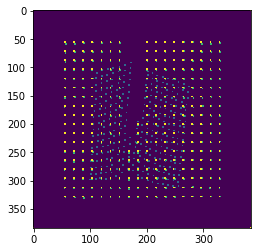

In [10]:
X, y = val_gen[3]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,324):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)